# Using data for optimal train usage

### Abstract
In this project, I am analyzing subway station entry data to recommend a train schedule that will optimize passenger experience by sending the most trains at the times of the most entries. By calculating an optimal train schedule based on the usage data, trains can be more efficiently used throughout the day. As a proof of concept, I focused on portions of the train 1 mta turnstile data only and compared it to the train 1 schedule. 

Based on my analysis, the peak usage of train 1 subways is slightly shifted from the peak hours of ridership. Instead, trains are arriving more frequently after peak ridership. For a train schedule that will more efficiently use trains, train arrivals should be shifted by 1 hour earlier allowing riders to get on them during peak hours. The same analysis can be applied to other trains to identify any need for an updated train schedule.

**Source of data: http://web.mta.info/developers/turnstile.html**

### Retrieve data 

In [1]:
#import libraries and packages
from sqlalchemy import create_engine
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [2]:
# data is stored in SQLite
# use engine to query data from SQL database
engine = create_engine('sqlite:///mta_data_project.db')

# load SQL database in python pandas
# df = dataframe (spreadsheet)
df = pd.read_sql('SELECT * FROM mta_data', engine)

# overview of dataset
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


### Clean data

Examine the data for duplicates. Define a duplicate as having the same turnstile identifier (C/A, Unit, SCP, Station) and the same date-time. A turnstile should only have 1 row since it should only have 1 value for the number of entries at a particular date and time. This code shows the existence of duplicates and then removes the rows with the fewest entries.

In [3]:
# create a datetime column 
df['DATE_TIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

# sort data in descending order (last entries first)
df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace = True, ascending=False)

In [4]:
# check for duplicates
# Note: each combination of C/A, UNIT, SCP, and STATION represents a unique turnstile 
# Each datetime should only have 1 entry per tunrstile
# grouping data by c/a, unit, scp to represent each station at each date time entry
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending=False)
.head(2))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
405945,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-08,2
2710700,S101,R070,00-00-02,ST. GEORGE,2021-10-02,2


In [5]:
# prevvious aggregate shows that station coney and st.george have 2 entries.
# what causes multiple entries per turnstile per datetime?
# Each datetime should only have 1 entry per tunrstile.
# create a mask to analyze station coney
mask = (df[(df['C/A'] == 'G001') &
          (df['UNIT'] == 'R151') &
          (df['SCP'] == '00-05-01') &
          (df['STATION'] == 'CONEY IS-STILLW') & 
          (df['DATE_TIME'] == '2021-11-08 00:00:00')])
mask

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
1292837,G001,R151,00-05-01,CONEY IS-STILLW,DFNQ,BMT,11/08/2021,00:00:00,REGULAR,327700,29,2021-11-08
1292838,G001,R151,00-05-01,CONEY IS-STILLW,DFNQ,BMT,11/08/2021,00:00:00,RECOVR AUD,0,367,2021-11-08


In [6]:
# 'CONEY IS-STILLW' has 2 entries at the same datetime: REGULAR and RECOVER AUD
# drop duplicate row of RECOVER AUD and keep REGULAR
df.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace=True)

In [7]:
# check that duplicate entries are removed
# each row should display 1 entry after aggregation
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending=False)
.head(2))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-09-25 00:00:00,1
1821692,R141,R031,00-03-02,34 ST-PENN STA,2021-12-21 15:00:00,1


In [8]:
# drop the desc column since we don't need it anymore
df = df.drop('DESC', axis = 1, errors= 'ignore')

# create a column to identify a unique turnstile combination to analyze stations 
df['TURNSTILE'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP'] + ' ' + df['STATION']
df.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,TURNSTILE
210382,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/24/2021,20:00:00,5562,994,2021-12-24 20:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT


### Calculate daily entries at a subway station
Each turnstile has a counter for the number of entries that doesn't reset at the end of each day - it keeps accumulating entries until the counter is reset. (The counters do get reset occassionally, although this will be handled below). In order to calculate the actual number of entries during a period of time, we need to look at the difference between the current counter value and the previous counter value. 

In [9]:
# create a subset of the original dataframe (df) with only the necessary columns for further analysis.
df2 = df[['TURNSTILE','LINENAME','STATION', 'DATE', 'DATE_TIME', 'ENTRIES', 'EXITS']]
df2 = pd.DataFrame(df2)

# sort the rows based on turnstile and time.
df2.sort_values(['TURNSTILE','STATION', 'DATE', 'DATE_TIME'], inplace = True, ascending = False)

df2.head(2)

,TURNSTILE,LINENAME,STATION,DATE,DATE_TIME,ENTRIES,EXITS
210382,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 20:00:00,5562,994
210381,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 16:00:00,5562,994


In [10]:
# Create columns containing the datetime and 
# the entries counter value of the previous row for a particular station.
# These will be used to calculate the actual number of entries at a particular time.
df2[['PREV_DATE_TIME', 'PREV_ENTRIES', 'PREV_EXITS']] = \
(df2.groupby(['TURNSTILE','STATION'], as_index = False)\
 [['DATE_TIME','ENTRIES', 'EXITS']]\
 .apply(lambda grp: grp.shift(1)))

In [11]:
# Drop rows that don't have values for the previous datetime and number of entries
# (since we can't calculate the difference)
df2.dropna(subset=['PREV_DATE_TIME'], axis = 0, inplace=True)

#check for null values
df2.isna().sum()
df2.head(1)

,TURNSTILE,LINENAME,STATION,DATE,DATE_TIME,ENTRIES,EXITS,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
210381,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 16:00:00,5562,994,2021-12-24 20:00:00,5562.0,994.0


#### Apply counter to entries and exits

Calculate actual entries and exits by applying a function that takes into account that a counter reset number of entries after it reaches a maximum count

In [12]:
# function returns entries data assuming counter was reset
# max_count: number at which counter resets
def entries_counter(row, max_count):
    
    # entries data are cumulative 
    # to calculate entries per day, take the difference from the previous day
    count = row['ENTRIES'] - row['PREV_ENTRIES']
    
    # if count is a negative value, assume that counter is in reverse,
    # get a positive value instead
    if count < 0:
        count = -count
    
    # assume counter was reset to 0, choose min value 
    if count > max_count:
        count = min(row['ENTRIES'], row['PREV_ENTRIES'])
    
    # check again if minimum value of entries is still greater than max count
    # return zero if that is the case
    if count > max_count:
        return 0
    
    return count

In [13]:
# exits counter, copied from entries_counter function
def exits_counter(row, max_count):
    count = row['EXITS'] - row['PREV_EXITS']
    if count < 0:
        count = -count
    if count > max_count:
        count = min(row['EXITS'], row['PREV_EXITS'])
    if count > max_count:
        return 0
    return count

Reset the counter at 172,800. Assumptions made:
* There are 86,400 seconds per day. 
* Assuming 2 entries per turnstile per second, a single turnstile can have up to 172,800 entries per day. 

In [15]:
# Now we can calculate actual entries from the cumulative entries.
# create a new column displaying actual entries per day
# apply entries_ounter function
df2['DAILY_ENTRIES'] = df2.apply(entries_counter, axis = 1, max_count = 172_800)

df2['DAILY_EXITS'] = df2.apply(exits_counter, axis = 1, max_count = 94_360)
df2.head(2)

,TURNSTILE,LINENAME,STATION,DATE,DATE_TIME,ENTRIES,EXITS,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
210381,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 16:00:00,5562,994,2021-12-24 20:00:00,5562.0,994.0,0.0,0.0
210380,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 12:00:00,5562,979,2021-12-24 16:00:00,5562.0,994.0,0.0,15.0


### Calculate total entries of each station

In [16]:
# calculate total entries (sum) for station
station_total_entries = (df2.groupby('STATION', as_index = False)
                         [['DAILY_ENTRIES', 'DAILY_EXITS']].sum()
                         .sort_values('DAILY_ENTRIES', ascending = False)
                         .reset_index())

station_total_entries.head(2)

,index,STATION,DAILY_ENTRIES,DAILY_EXITS
0,61,34 ST-PENN STA,4841767.0,6930502.0
1,258,JOURNAL SQUARE,3722143.0,2604363.0


Text(0.5, 1.0, 'Total entries of the top 10 busiest stations')

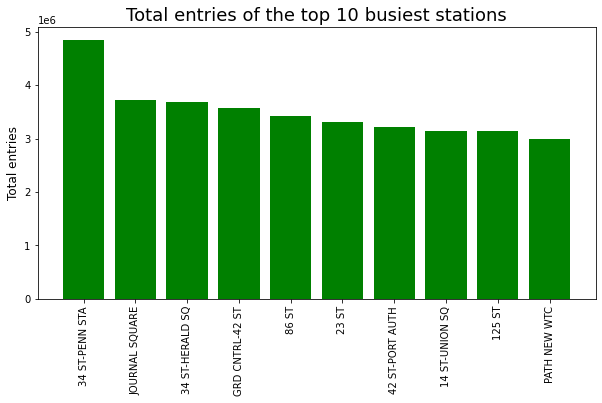

In [17]:
# plot bar chart displaying total entries of top 10 stations 
plt.figure(figsize=[10,5])

plt.bar(x = station_total_entries['STATION'][:10], height = station_total_entries['DAILY_ENTRIES'][:10], \
        color='green')
plt.xticks(rotation = 90)
plt.ylabel('Total entries', size=12)
plt.title('Total entries of the top 10 busiest stations', size=18)

* The busiest station is 34 ST-PENN STA.
For analyis, I'd like to scope on the trains through this station

In [18]:
# Filter data by station
station_datetime_entries = (df2.groupby(['STATION', 'DATE_TIME'], as_index = False)
                        [['DAILY_ENTRIES', 'DAILY_EXITS']]
                        .sum())
station_datetime_entries.head(2)

,STATION,DATE_TIME,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,2021-09-25 00:00:00,585.0,1262.0
1,1 AV,2021-09-25 04:00:00,225.0,760.0


### Analysis

* Station: 34 ST-PENN STA (busiest station)

* This station serves 6 lines: 1,2,3,A,C,E (Source: [MTA subway may](https://new.mta.info/maps))

* Line: Pick train 1

* Days: weekdays only

* Train schedule timetable does not have exact time for 34 ST-PENN STA, so I will look at the other stations on line 1 that are on the train schedule

In [ ]:
# filter Weekday entries at stations
# ceate a column with hour of the day
station_datetime_entries['TIME'] = station_datetime_entries['DATE_TIME'].dt.time

# create a column with day of the week as displayed as a number
# number 0 - 4 is Monday to Friday
# number 5 is saturday and 6 is sunday
station_datetime_entries['DAY_OF_WEEK'] = pd.to_datetime(station_datetime_entries['DATE_TIME']).dt.dayofweek

# Filter to show weekdays only
weekday_station_entries = (station_datetime_entries[
    (station_datetime_entries['DAY_OF_WEEK'] != 5) & 
    (station_datetime_entries['DAY_OF_WEEK'] != 6)])

weekday_station_entries.head(2)

### Load train1 schedule

In [ ]:
# Load train schedule as an excel file
# Source: https://new.mta.info/schedules
# Copied timetable from a .pdf file into an excel file.
train_1_schedule = pd.read_excel('Train_1_schedule2.xlsx')

# Get names of all stations that train 1 travels too
stations_name = list(train_1_schedule.columns)
stations_name

In [ ]:
# time is in the format hh:mm:ss
# round the timestamp to the nearest hour
# return hour as an integer
# e.g. 03:30:00 will return the integer 4
def round_hour(TIME):
    
    # round hour up if it is greater than 30 min else round hour down
    # e.g 03:35:00 will return 04:00:00
    if TIME.minute >= 30:
        timeString = str(TIME.replace(second=0, microsecond=0, minute=0, hour=TIME.hour+1))
    else:
        timeString = str(TIME.replace(second=0, microsecond=0, minute=0))
        
    # only return the hour portion of TIME diplayed as two digits (e.g. 04, 12, and etc)
    # for single digit hour (e.g 04) we will return the second digit (index 1), omitting the zeros
    # e.g 04 will return 4
    # for 2 digits hour (e.g 12) we will return both digits (index 0:2)
    if timeString[0] == '0':
        return int(timeString[1])
    
    else:
        return int(timeString[0:2]) 

In [ ]:
# filter ridership for weekdays only
def station_ridership(station_name):
    
    #Filter station with station name from weekday_station_entries
    station_entries = (weekday_station_entries
                  [weekday_station_entries['STATION'] == station_name])

    # apply function round_hour to round timestamp to the nearest hour
    # Create an HOUR column where we round time to nearest hour
    station_entries['HOUR'] = station_entries.loc[:,'TIME'].apply(round_hour)
    
    return station_entries

In [ ]:
# calculate hourly entries given a station name
def hourly_entries(station_name):

    #calculate weekday entries using 'station_ridership' given station_name
    df = station_ridership(station_name)
    
    # calculate hourly entrries 
    hourly_entries = (df.groupby('HOUR', as_index=False)
                   ['DAILY_ENTRIES'].mean()
                   .sort_values('HOUR'))
    
    hourly_entries = hourly_entries.rename(columns={'DAILY_ENTRIES':station_name}) 
    
    return hourly_entries

In [ ]:
# calculate hourly exits given a station name
# similar to hourly entries function
def hourly_exits(station_name):

    #calculate exits at the station using function 'station_ridership'
    df = station_ridership(station_name)
    hourly_exits = (df.groupby('HOUR', as_index=False)
                   ['DAILY_EXITS'].mean()
                   .sort_values('HOUR'))
    
    # update name to exits
    hourly_exits = hourly_exits.rename(columns={'DAILY_EXITS':station_name}) 
    
    return hourly_exits

In [ ]:
hourly_exits(stations_name[0])

#### Hourly exits stations with train 1

In [ ]:
# apply function hourly_exits for each station to show number of exits at each hour
# stations_name is a list of stations name where train 1 runs through

# create a table showing cumulative exits for each station at each hour

# initialize a table with first station name
hourly_exits_df = hourly_exits(stations_name[0])

for i in range(1, len(stations_name)):
    tables = hourly_exits(stations_name[i])
    # add stations_name to previously created table 'hourly_exits'
    hourly_exits_df = pd.merge(hourly_exits_df, tables, on='HOUR', how='outer')
    
hourly_exits_df = hourly_exits_df.sort_values('HOUR')
hourly_exits_df = hourly_exits_df.fillna(0)

hourly_exits_df.head(2)

#### Hourly entries stations with train 1

In [ ]:
# create a table showing cumulative entries for each station at each hour
# similar to exits table
hourly_entries_df = hourly_entries(stations_name[0])

for i in range(1, len(stations_name)):
    tables = hourly_entries(stations_name[i])
    hourly_entries_df = pd.merge(hourly_entries_df,tables, on='HOUR', how='outer')
    
hourly_entries_df = hourly_entries_df.sort_values('HOUR')
hourly_entries_df = hourly_entries_df.fillna(0)

hourly_entries_df.head(1)

### Schedule of Train 1 

In [ ]:
# Round up time stamp to the nearest hour
# e.g. 1:14:00 will return 2 
# Timestamp in 24 hour format
# Return values ranging from 0 to 23. 
# 24:00 (midnight) will return 0, while 23:00 (11:00 PM) will return 23)

def convert_to_hour(TIME):
    # return -1 for strings, blank spaces and anything that is not a time object. 
    if (isinstance(TIME, str)) or (isinstance(TIME, float)):
        return -1
    
    # Round up timestamp to the nearest hour
    if TIME.minute > 0:
        hour = TIME.hour + 1
    else:
        hour = TIME.hour
        
    if (hour == 24):
        return 0
    return hour

# apply function to column
def convert_column(col):
    return col.apply(convert_to_hour)

In [ ]:
# calculate how many trains arriving each hour 
# Each value in the dataframe represents one train arriving at the hour. 
train_1_hourly = train_1_schedule.apply(convert_column)

train_1_hourly.head(2)

In [ ]:
# group column by hour and count entries
first_column = True;
total = None;

for col in train_1_hourly.columns:
    countColumn = "SOUTH FERRY"
    if col == "SOUTH FERRY":
        countColumn = "CHAMBERS ST"
    
    num_trains = train_1_hourly.groupby(col, as_index=False).count()\
    .rename(columns={col:'HOUR', countColumn:col})
    num_trains = num_trains[["HOUR", col]]

    if first_column == True:
        total = num_trains
        first_column = False
    else:
        total = pd.merge(total, num_trains, on="HOUR", how="outer")

In [ ]:
total = total.sort_values('HOUR')

In [ ]:
# drop first row. First row contains empty values. 
total = total.iloc[1: , :]

* Trains come from both sides of the terminal (Bronx and Manhattan bound)
To account for that, multiply the trains numbers by 2

In [ ]:
total_trains1 = total.apply(lambda x: x*2)
# Hour column should remain in the previous value
total_trains1['HOUR'] = total_trains1['HOUR']/2

In [ ]:
total_trains1.head(2)

### Graph entries or exits of selective stations on line 1 with train schedule

In [ ]:
# Plot entries of selective stations on line 1 with one train schedule

# stations_name: list of stations name
# hourly_df: hourly_entries_df or hourly_exits_df
# entries_or_exits: string for 'exits' or 'entries'

def ridership_schedule(stations_name, hourly_df, entries_or_exits):
    fig, ax1 = plt.subplots(figsize=[12,6])
    label = entries_or_exits

    # set title
    ax1.set_title('{} of stations with train 1'.format(label), fontsize=16, weight='bold')

    # set ticks
    ticks_size = 12
    ax1.set_xticks(np.arange(0,24,1))
    ax1.tick_params(axis='both', labelsize=ticks_size)

    # set axis labels
    label_size = 12
    ax1.set_xlabel('Hour', fontsize=label_size) 
    ax1.set_ylabel(label, fontsize=label_size)

    legend_size = 12

    df = hourly_df
    for i in range(len(stations_name)):
        ax1.plot(df['HOUR'], df[stations_name[i]],label=stations_name[i], linestyle='--')
        ax1.legend(fontsize=legend_size)

    # Plot train schedule of 96 ST, located ~ halfway of line 1   
    ax2 = ax1.twinx()
    ax2.plot(total_trains1['HOUR'], total_trains1['96 ST'], \
             color = 'black',label ='# of Trains')

    ax2.set_ylabel("Number of train 1",fontsize=label_size)
    ax2.legend(fontsize=legend_size)
    ax2.tick_params(axis='y', labelsize=ticks_size)

In [ ]:
# Plot exits
ridership_schedule(stations_name, hourly_exits_df, 'Exits')
plt.savefig('exits_train1.png')

In [ ]:
# Plot entries
ridership_schedule(stations_name, hourly_entries_df, 'Entries')
plt.savefig('entries_train1.png')

* Observations:
Ridership and entries and exits do not alighn with peak time of train arrival

### Plot station entries and exits with schedule of train 1

In [ ]:
# Function to plot entries, exits, and train schedule of a station into one plot
def plot_train_station2(station_name, ax1):  
    station_df = hourly_entries(station_name)
    
    # set title
    ax1.set_title('Station: {}'.format(station_name), fontsize=10, weight='bold')
    
    # set axis labels
    label_size = 8
    ax1.set_xlabel('Hour', fontsize=label_size) 
    ax1.set_ylabel('Entries', fontsize=label_size) 

    #set ticks
    ticks_size = 8
    ax1.set_xticks(np.arange(0,24,2), fontsize=ticks_size)
    ax1.tick_params(axis='both', labelsize=ticks_size)

    # Entries
    ax1.plot(station_df['HOUR'], station_df[station_name],\
             color = 'blue', label='Entries') 
    
    exits_df = hourly_exits(station_name)
    # Exits data
    ax1.plot(exits_df['HOUR'], exits_df[station_name],\
             color = 'green', label='Exits') 
      
    # Train data
    ax2 = ax1.twinx() 

    ax2.plot(total_trains1['HOUR'], total_trains1[station_name],\
             color = 'red', linestyle='--', label='# of Trains') 
    
    # set axis labels
    ax2.set_ylabel('Number of train 1', color = 'red', fontsize=label_size) 
    
    #set ticks
    ax2.tick_params(axis='y', labelsize=ticks_size)
    ax2.set_yticks(np.arange(0,31,5), fontsize=ticks_size)
    
    # legend
    legend_size = 8
    ax1.legend(loc=1, bbox_to_anchor=(0.26, 1), fontsize=legend_size)
    ax2.legend(loc=1, bbox_to_anchor=(0.26, 0.85), fontsize=legend_size)

In [ ]:
# Make subplots of exits, entries, train schedule for each station.
fig, axs = plt.subplots(5, 2, figsize=[12,26])

for i in range(len(stations_name)):
    first_index = i // 2
    second_index = i % 2
    plot_train_station2(stations_name[i], axs[first_index, second_index])    
plt.savefig('subplots_train1.png')

* In the individual subplots, we observe that the peak hours of trains do not align with the peak hours of entries or exits at the station

* For the majority of stations, the peak hours for entries and exits align with each other. This means people get on and off at these stations on the peak hours

* For the stations in the neighborhouds (Bronx, station 238 ST), we observe peak entries in the mornings ~ 4am and peak exits in the afternoon ~ 16.00 PM